In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path, walk, listdir
from os.path import isfile
from statistics import fmean
import re
from tqdm import tqdm

# Constants

In [2]:
RUNTIME_SECONDS = 3600

DIR_CLASSIC = "../bench_data/classic/"
DIR_MODIFIED = "../bench_data/modified/"

REGEX_NODES = r"\d+_nodes"
REGEX_VERSION = r"(modified)|(classic)"
REGEX_DURATION = r"\d+_minutes"
REGEX_RUN = r"run_\d+"

# Utility Functions

In [3]:
def find_all_csvs(rootpath : str) -> list[str]:
    csvs = []
    for root, dirs, files in walk(rootpath):
        for dir in dirs:
            dir_path = path.join(root, dir)
            csvs = csvs + [path.normpath(path.abspath(path.join(root, dir, file))) for file in listdir(dir_path) if file.endswith('csv')]
    return csvs

def find_all_csvs_and_join(rootpaths : list[str]) -> list[str]:
    csvs = []
    for path in rootpaths:
        csvs = csvs + find_all_csvs(path)
    return csvs

In [4]:
FILES = find_all_csvs("..\\bench_data")

In [5]:
def open_csv(path : str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df.leaderId != -1] # Remove the initial dummy entries
    return df

In [6]:
def find_node_count(df : pd.DataFrame) -> int:
    return len(df["serverId"].unique())

In [7]:
def find_quorum_size(df : pd.DataFrame) -> int:
    return find_node_count(df) // 2 + 1

In [8]:
def get_node_count(file : str) -> int:
    num, _ = re.search(REGEX_NODES, file).group().split("_", maxsplit=1)
    return int(num)

def get_duration_minutes(file : str) -> int:
    num, _ = re.search(REGEX_DURATION, file).group().split("_", maxsplit=1)
    return int(num)

def get_algorithm_type(file : str) -> str:
    return re.search(REGEX_VERSION, file).group()

def get_run_id(file : str) -> str:
    return re.search(REGEX_RUN, file).group()

# Work per Leader

## Committed entries

In [9]:
def plot_leader_commit_counts(df : pd.DataFrame, title=None):
    leaders = df["leaderId"].value_counts()
    leaders = leaders / len(df)
    # plt.bar(leaders.index, leaders)
    sns.barplot(leaders)
    plt.ylim(0,1)
    if not title is None:
        plt.title(title)
    plt.show()

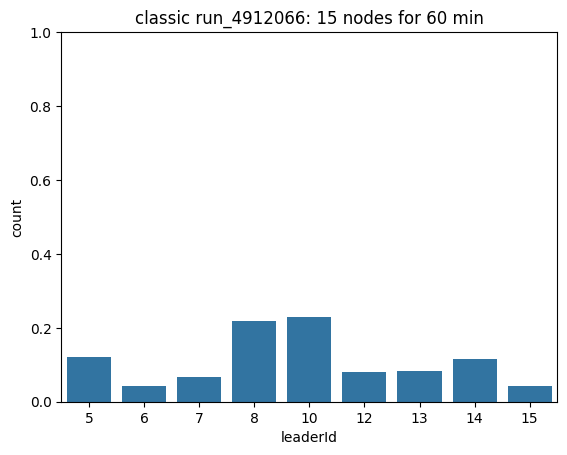

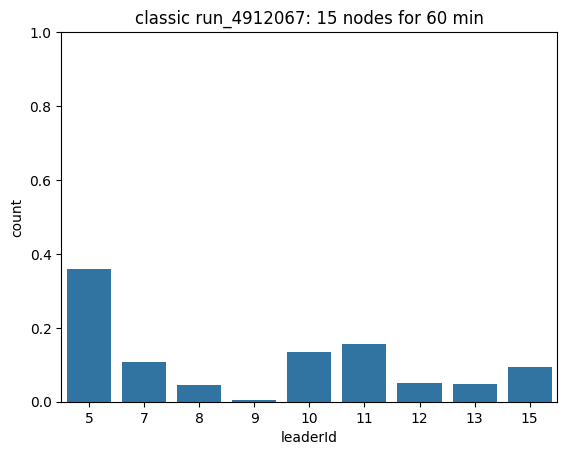

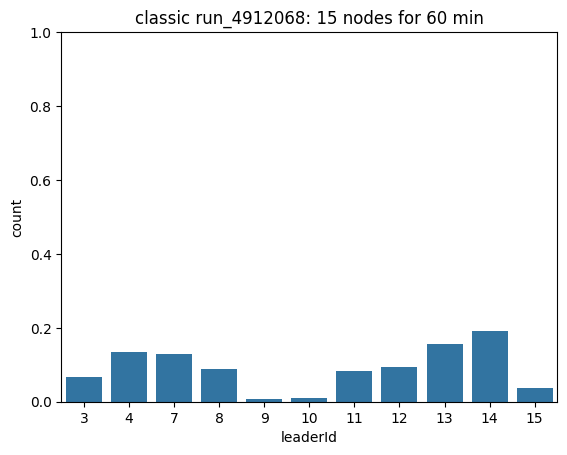

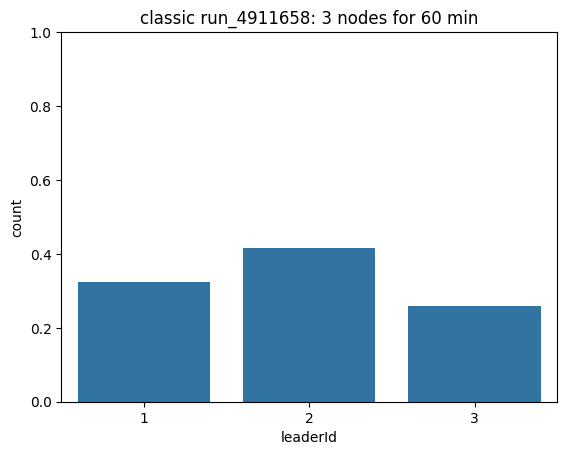

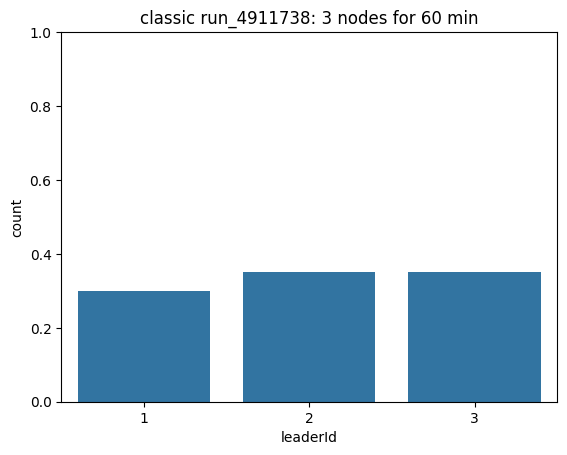

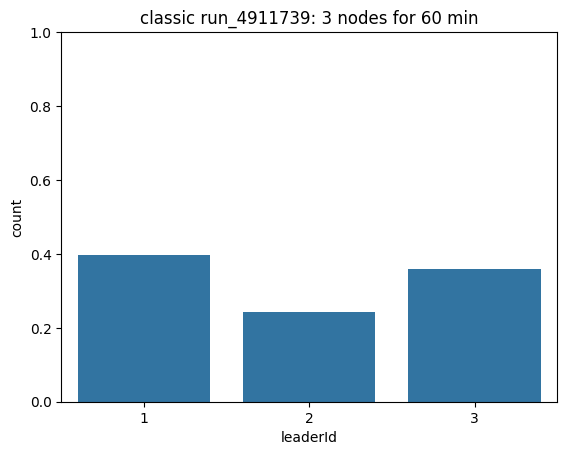

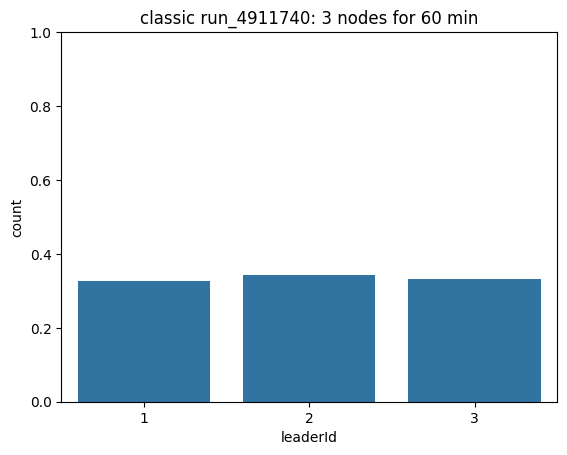

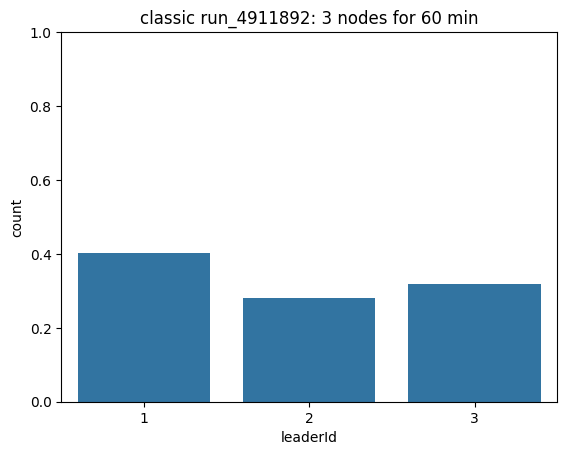

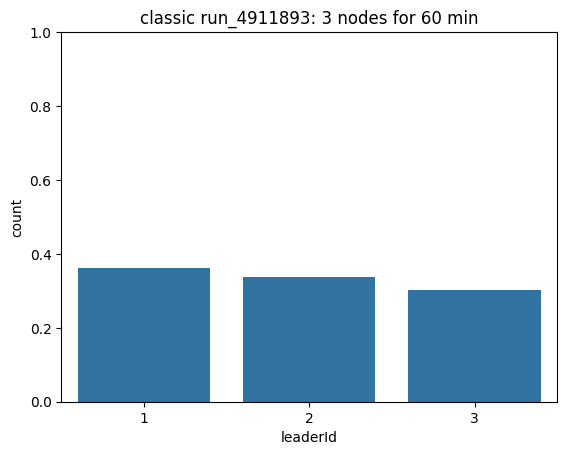

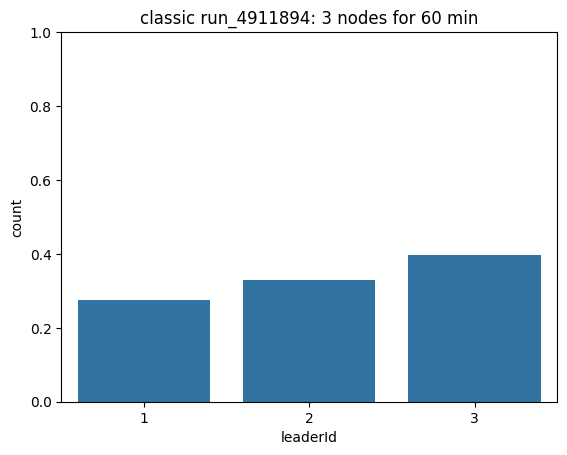

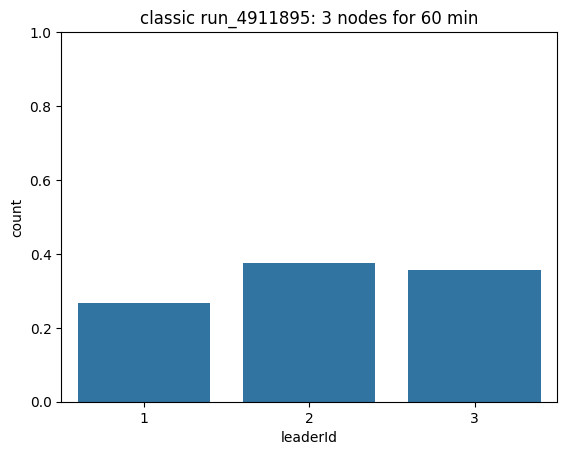

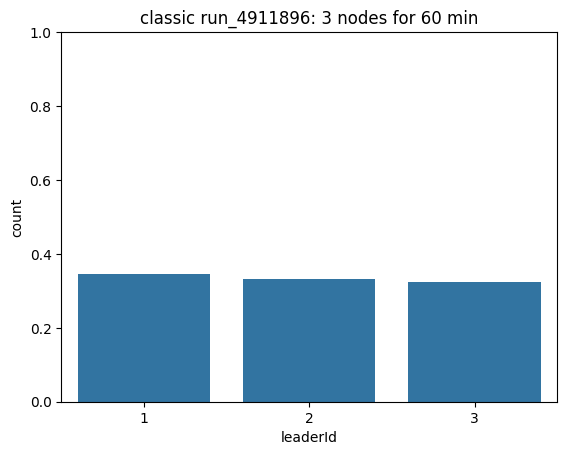

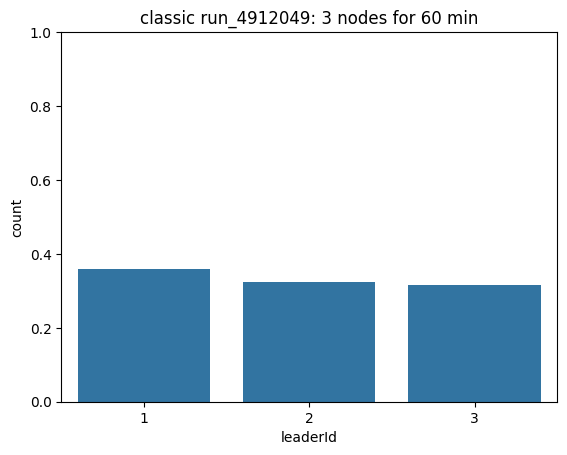

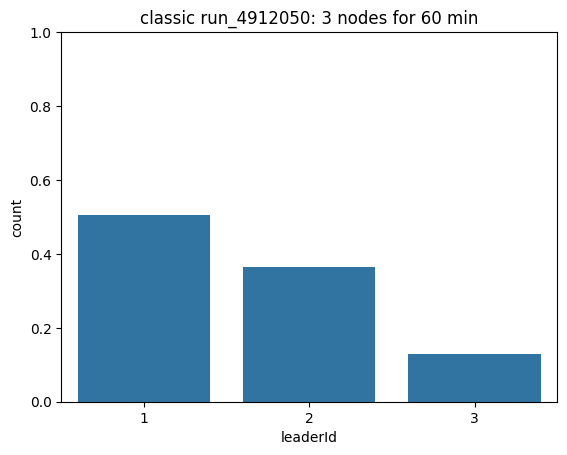

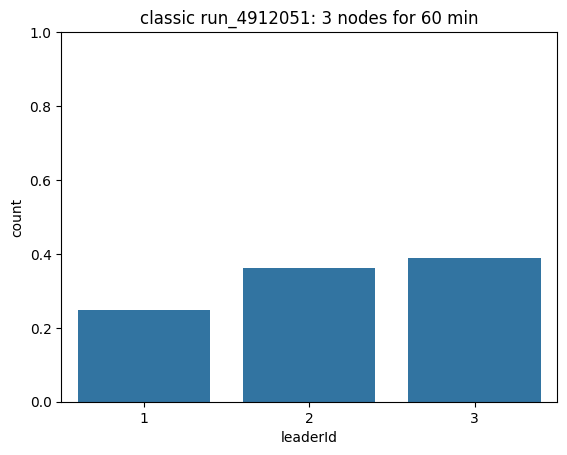

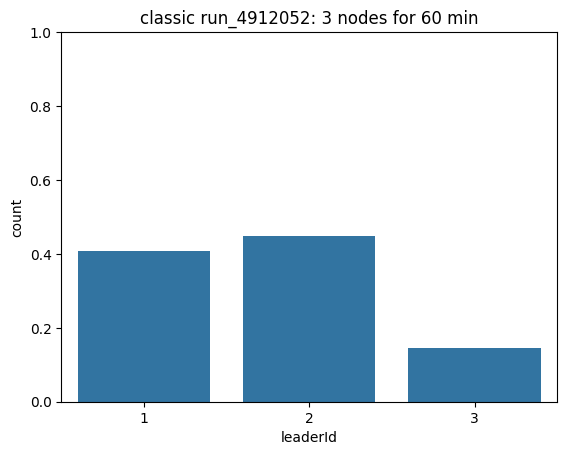

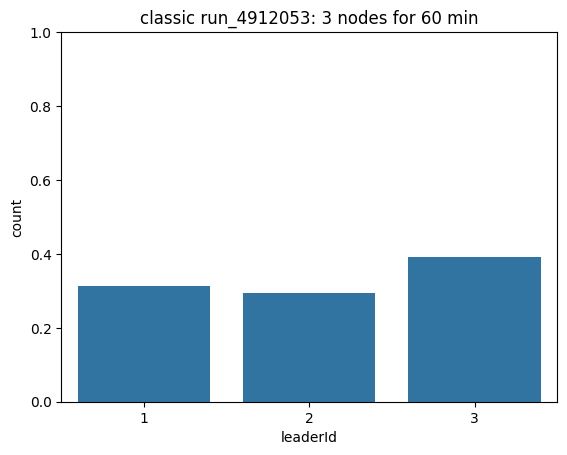

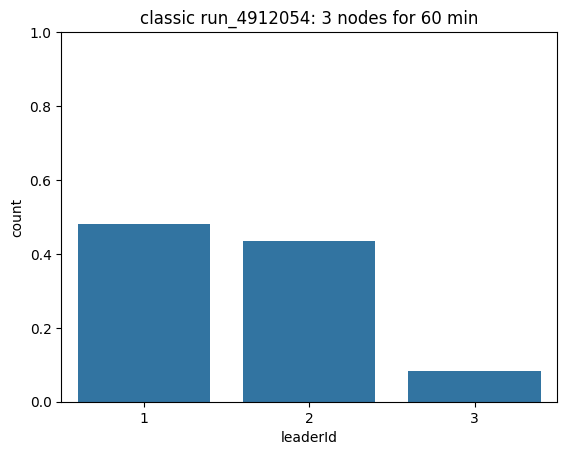

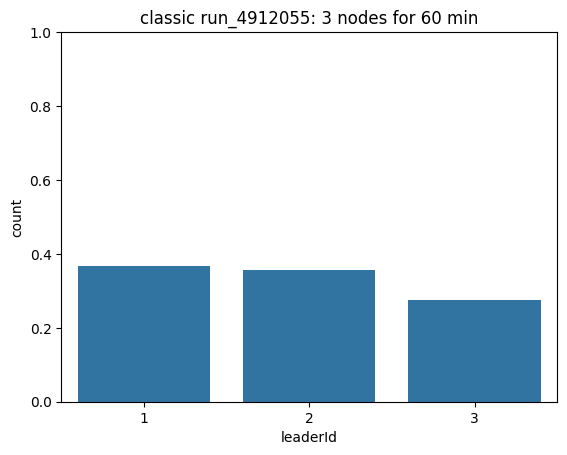

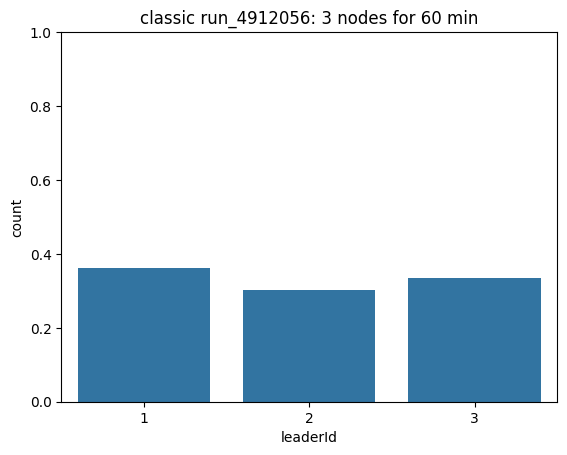

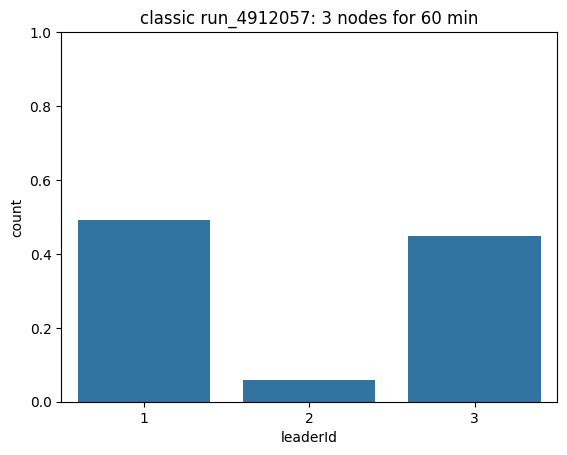

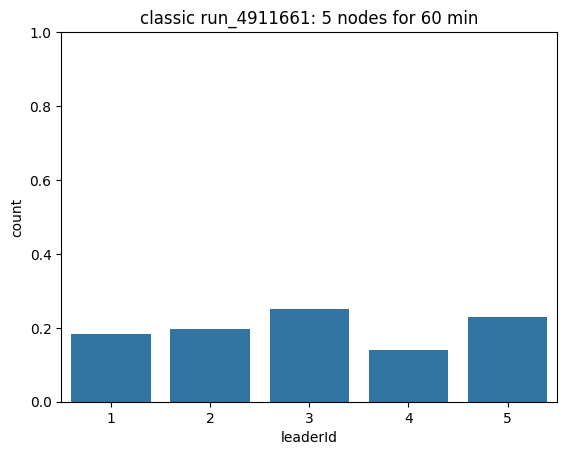

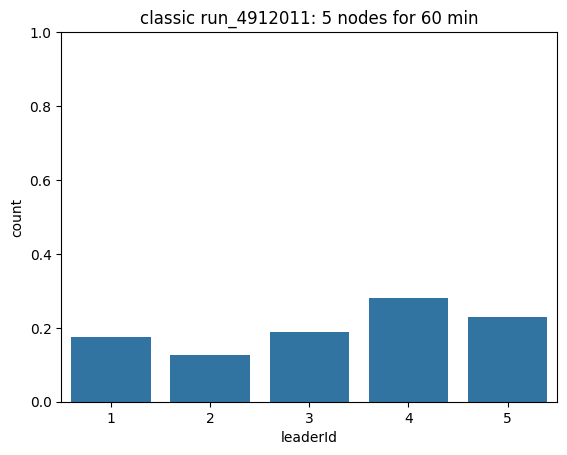

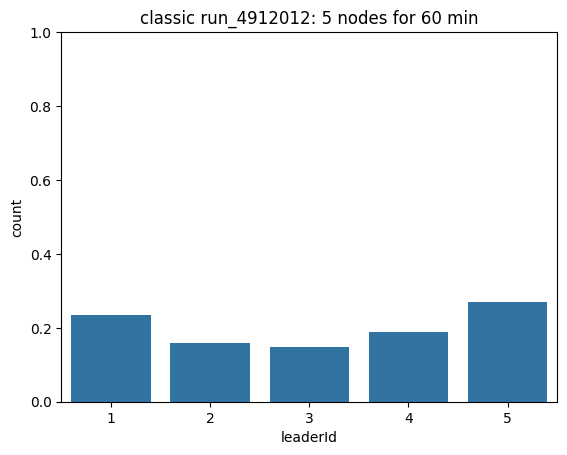

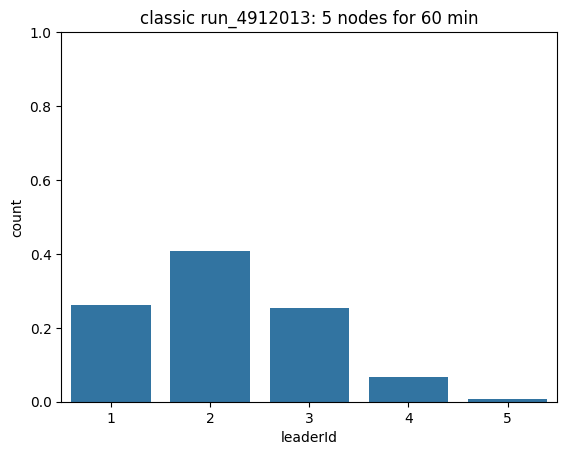

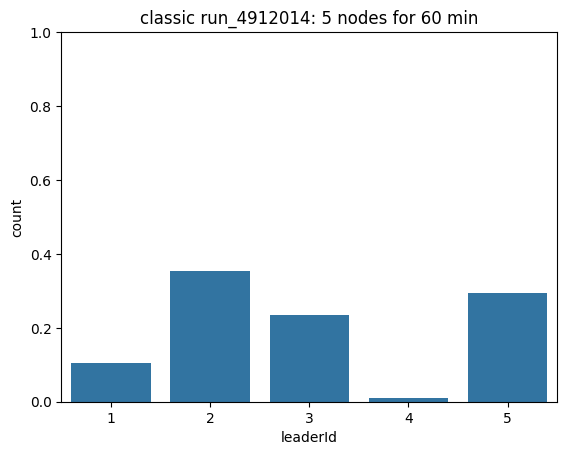

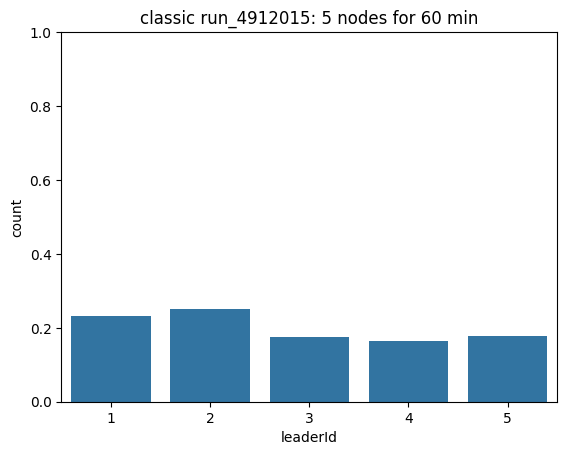

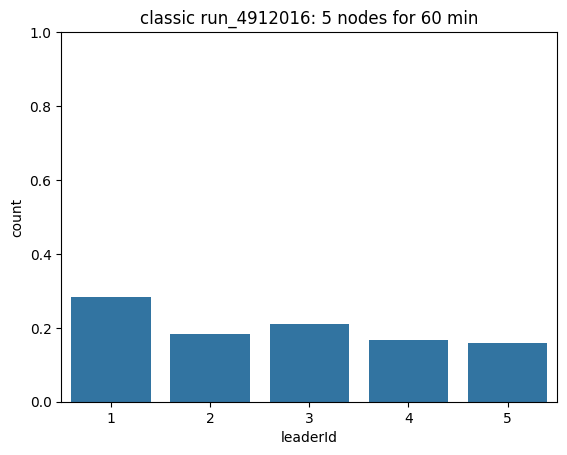

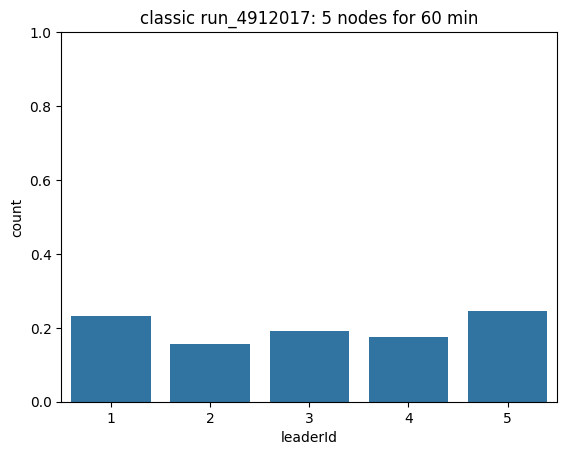

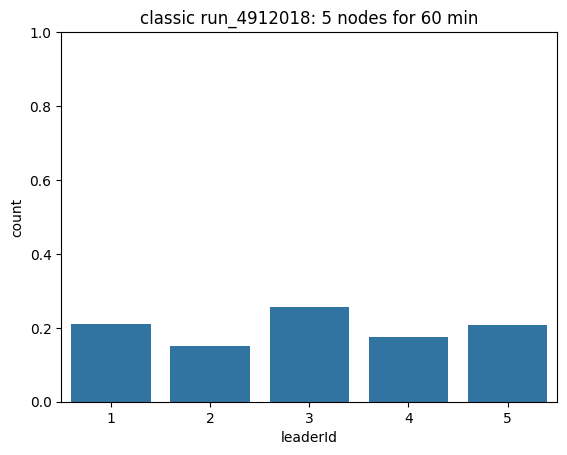

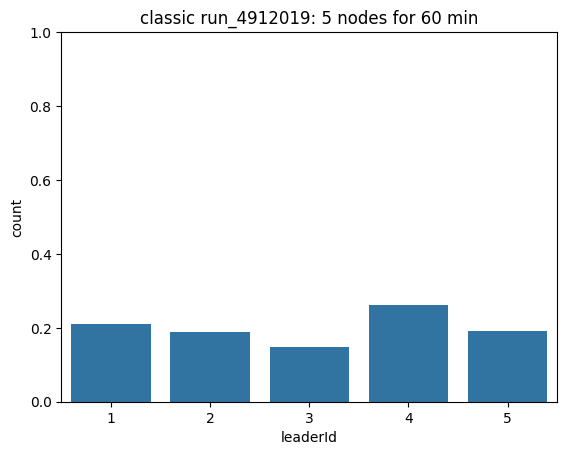

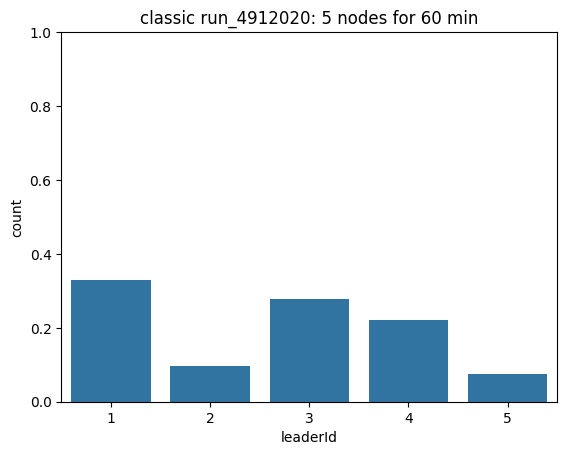

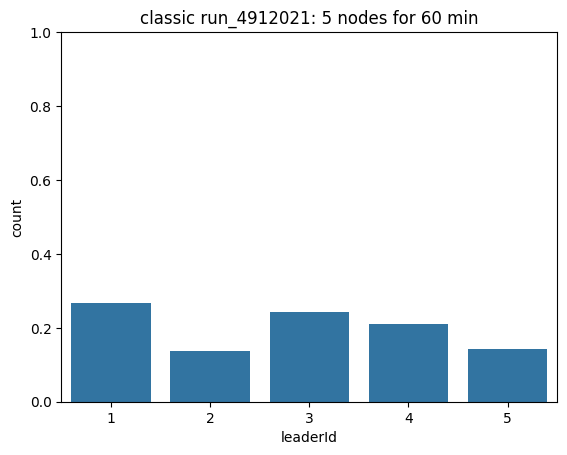

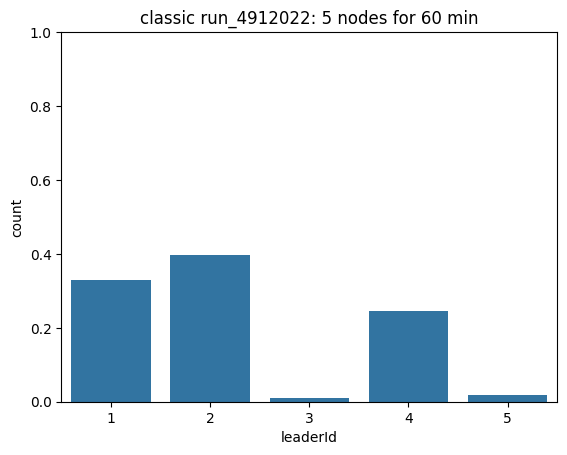

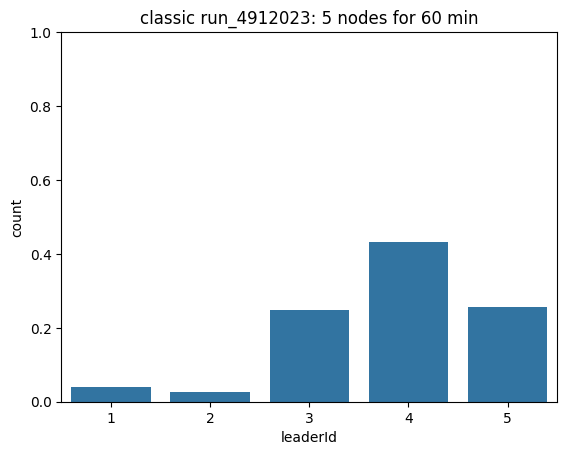

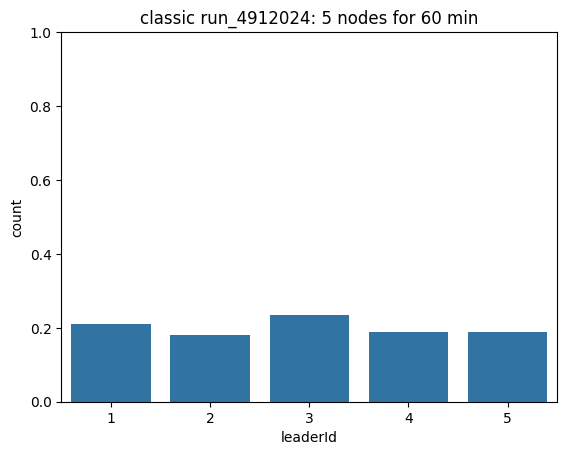

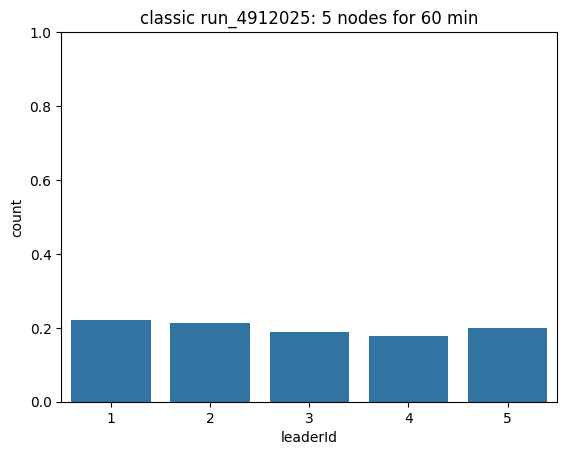

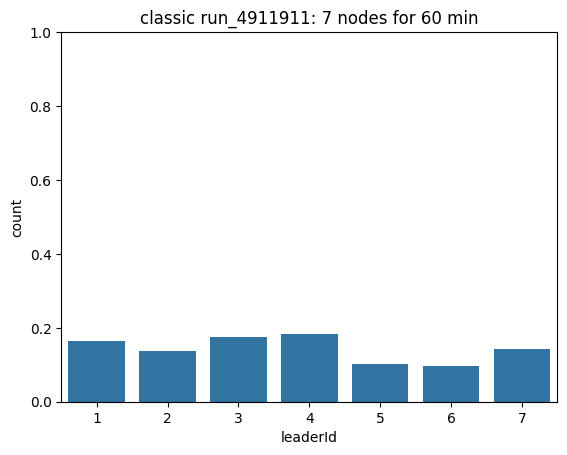

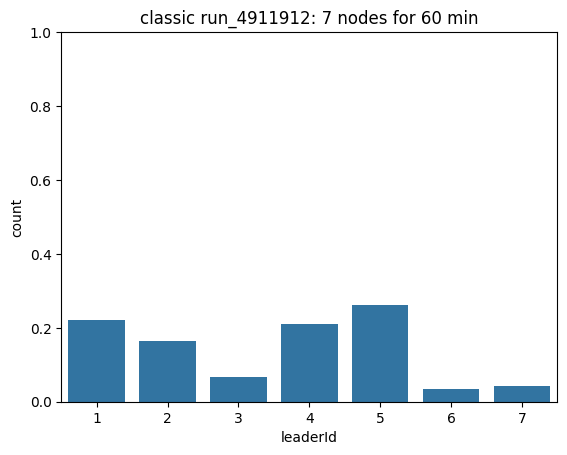

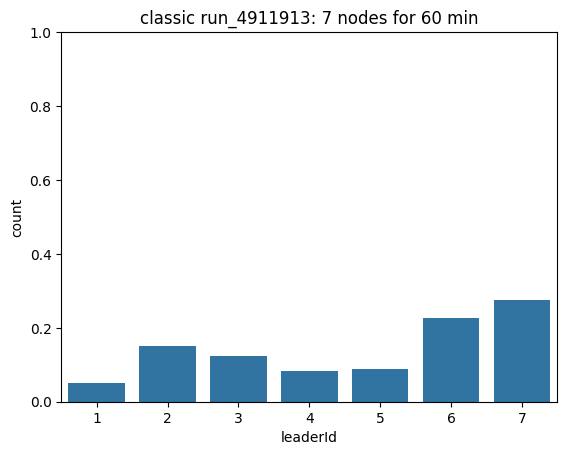

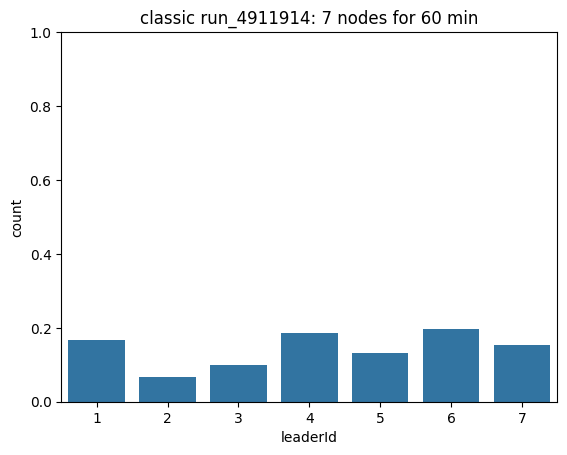

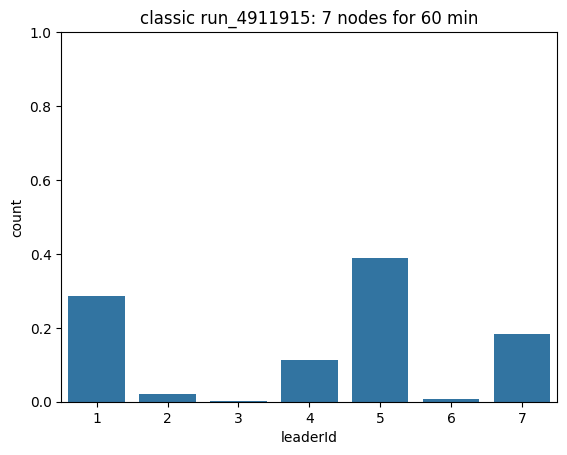

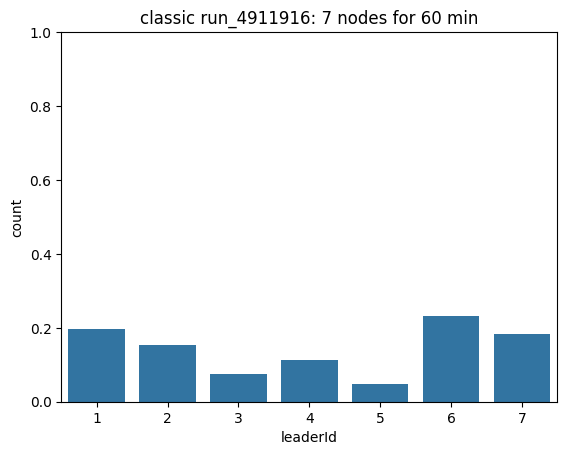

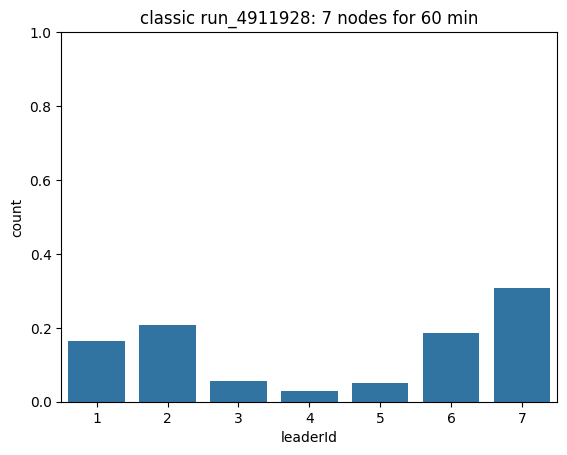

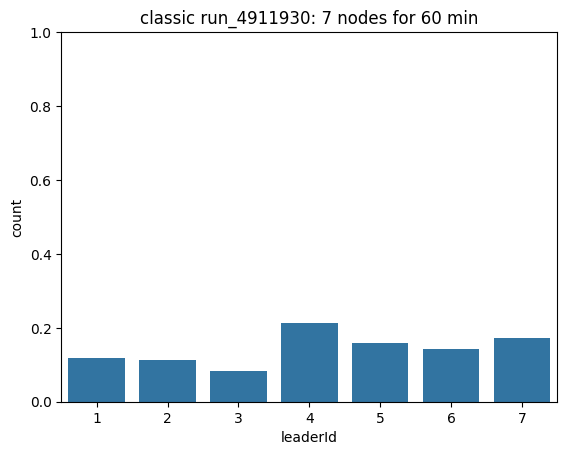

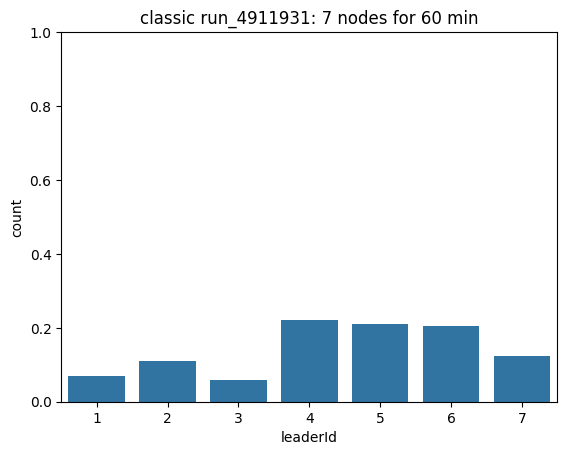

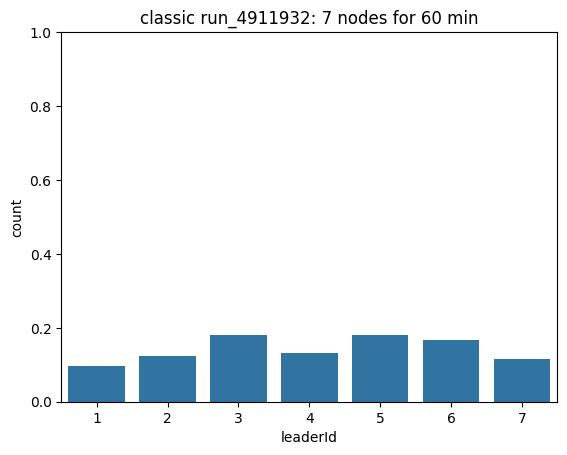

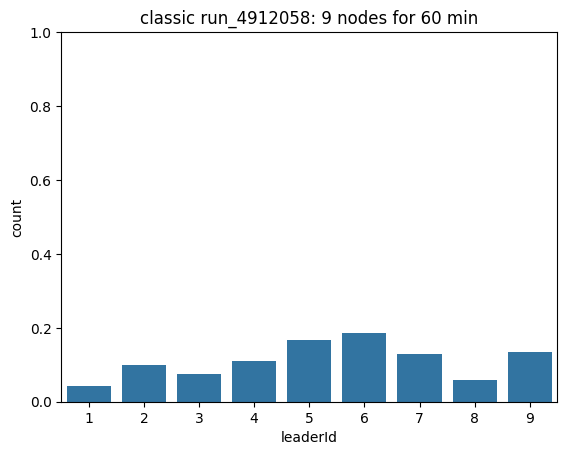

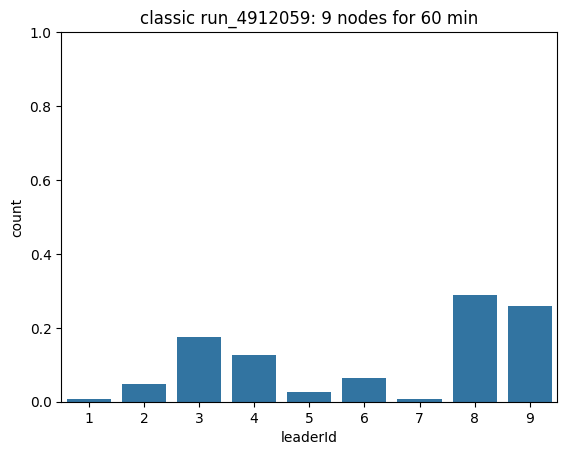

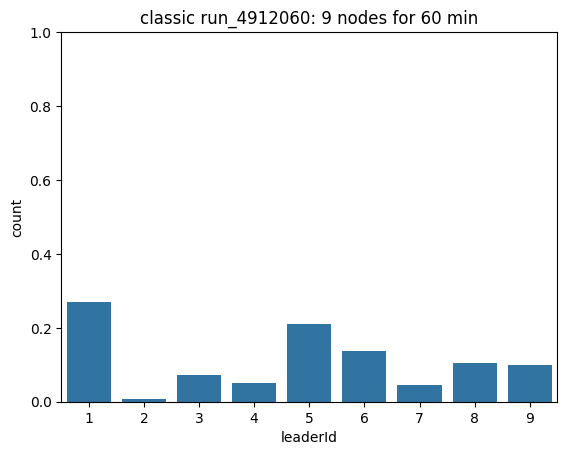

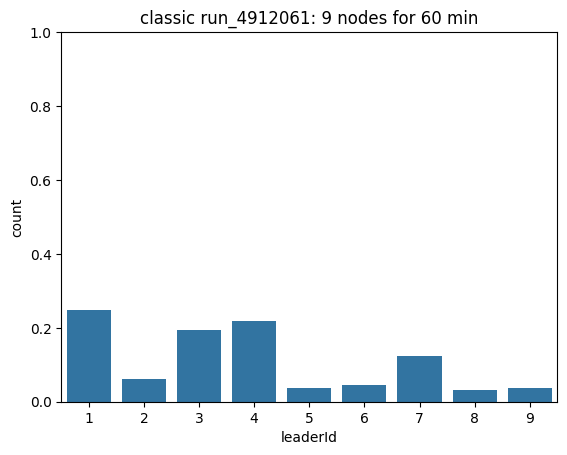

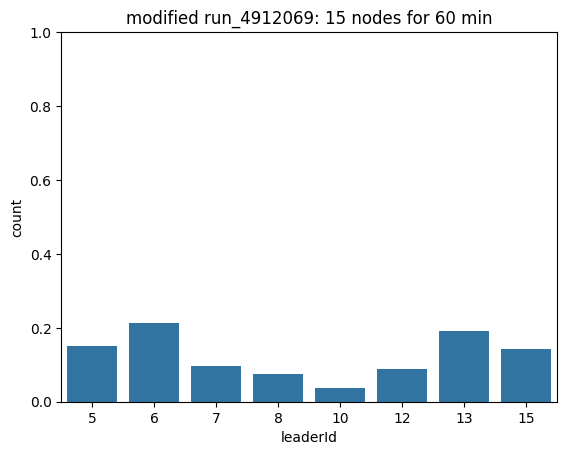

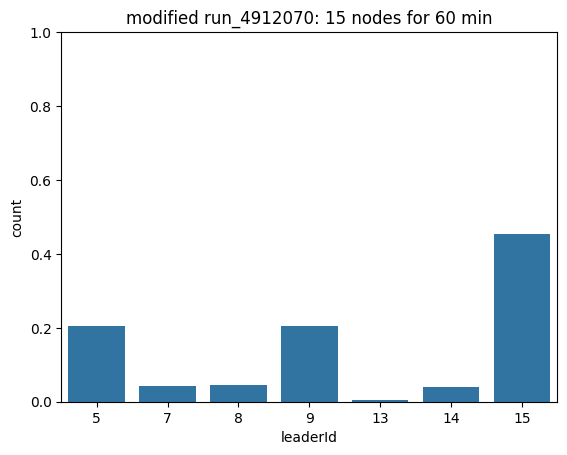

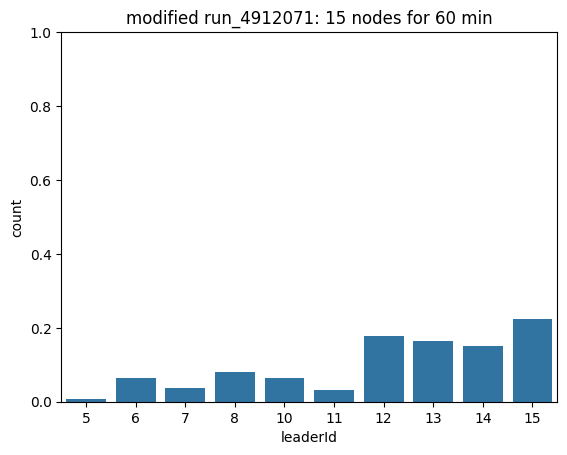

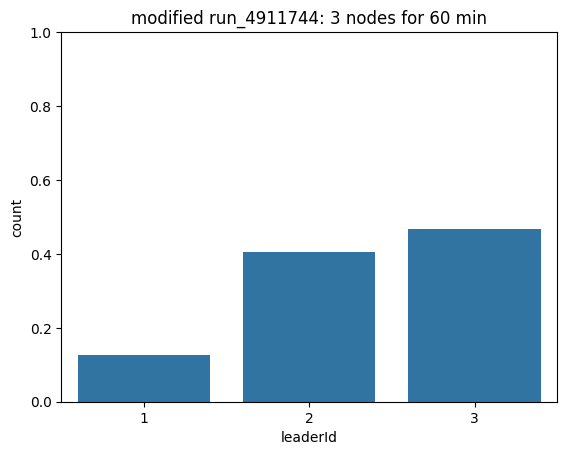

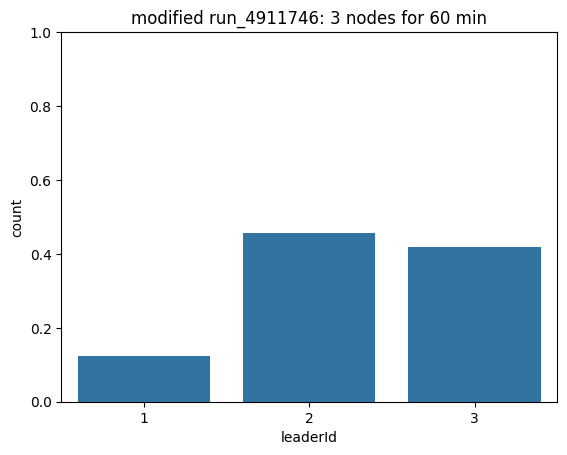

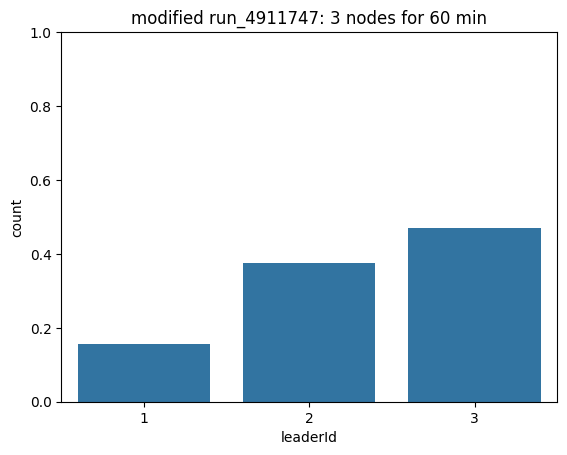

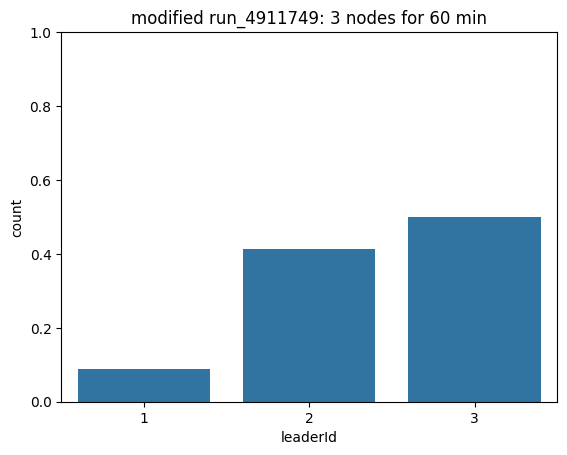

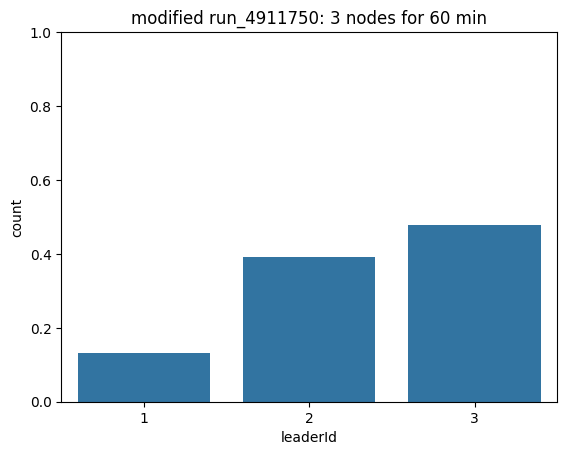

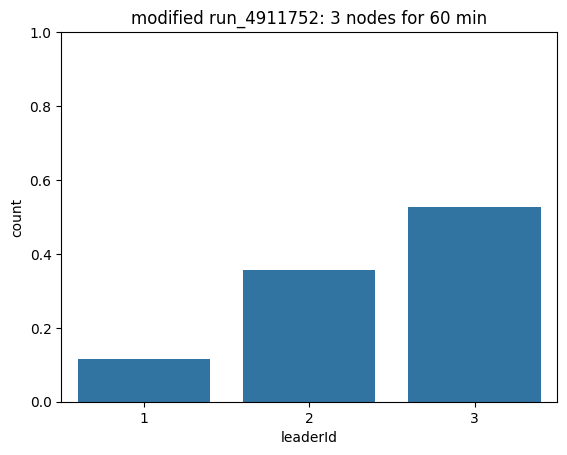

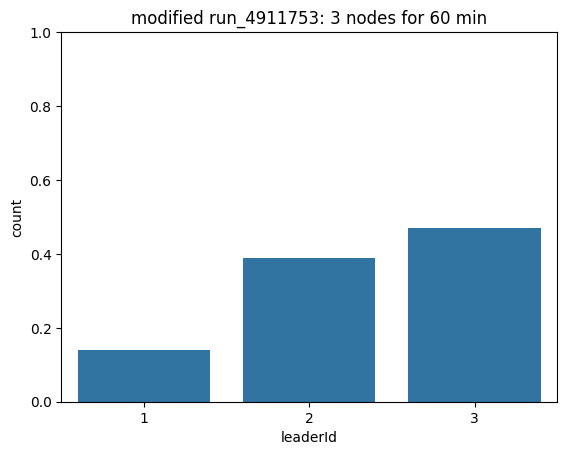

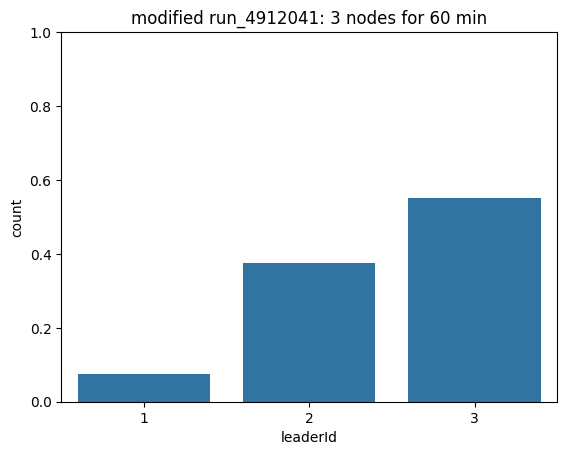

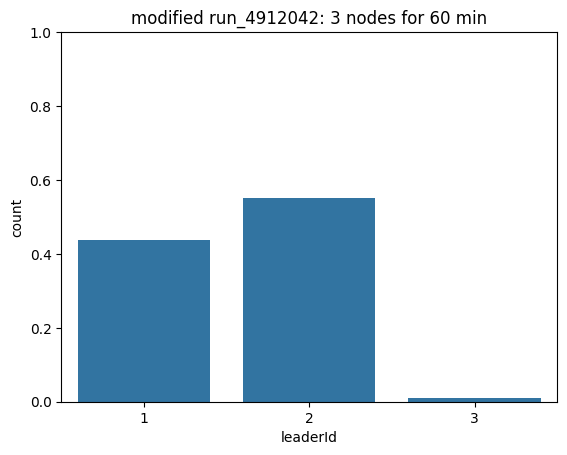

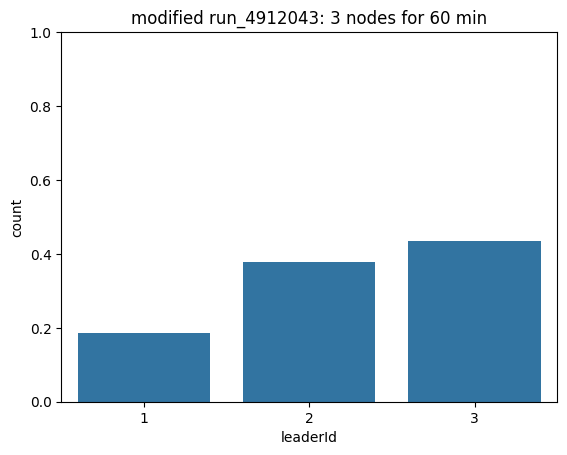

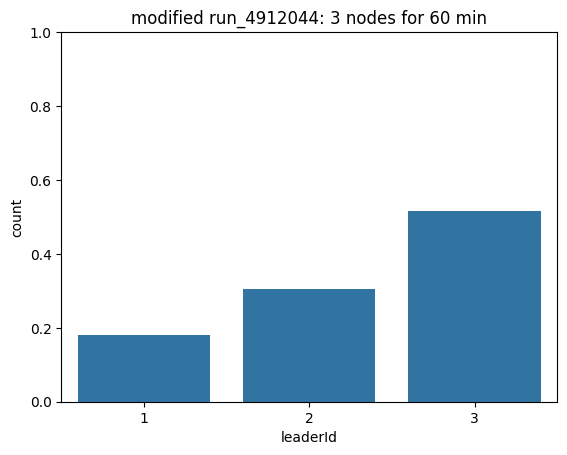

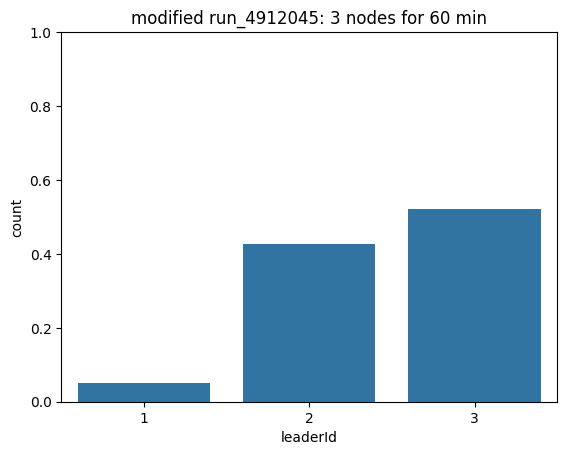

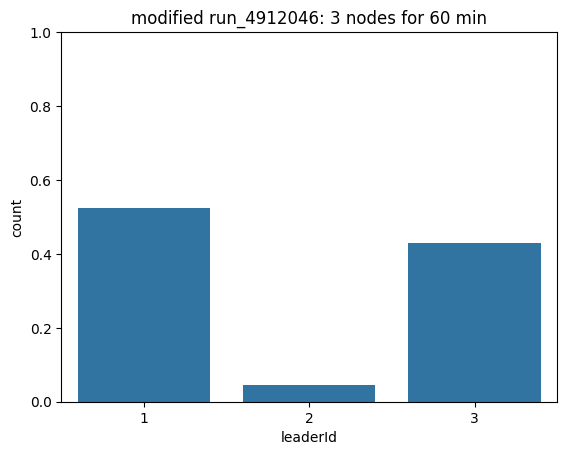

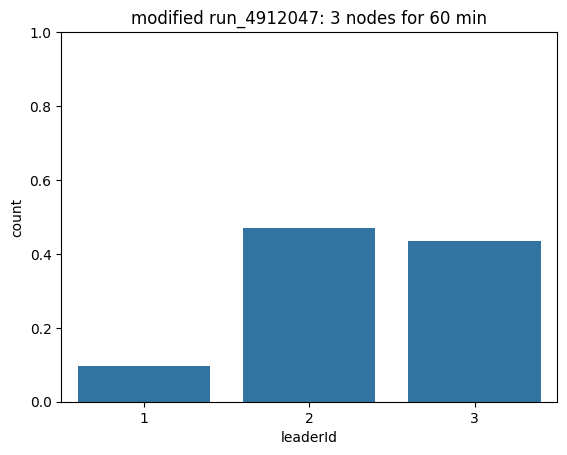

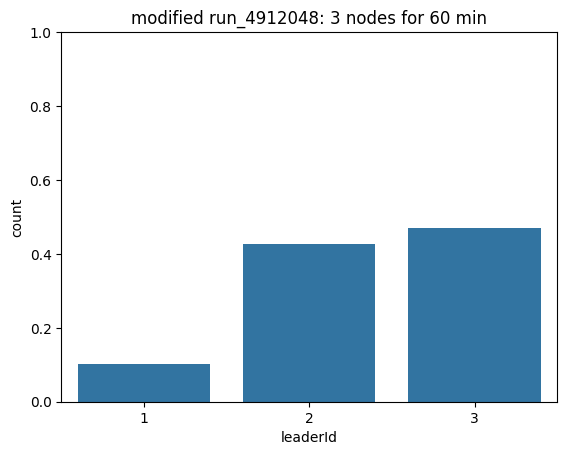

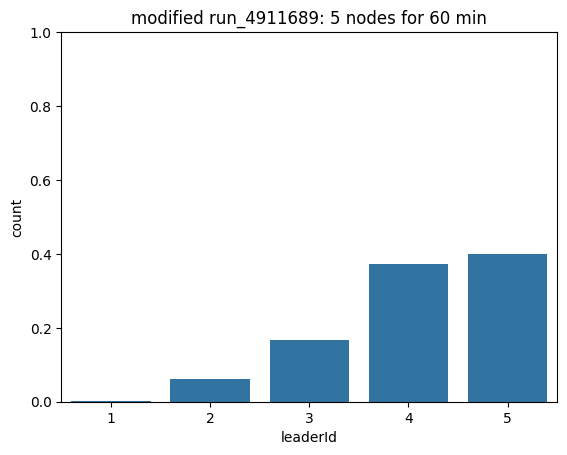

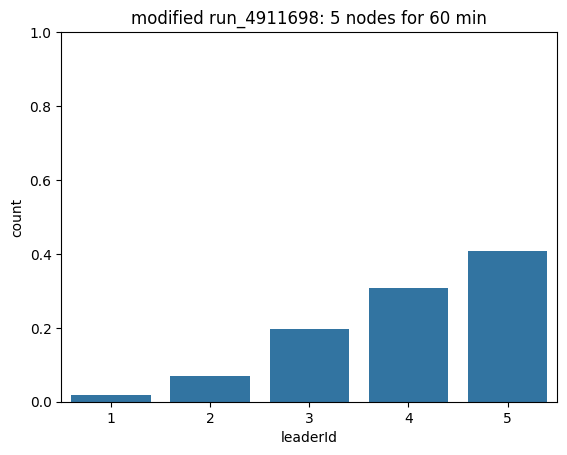

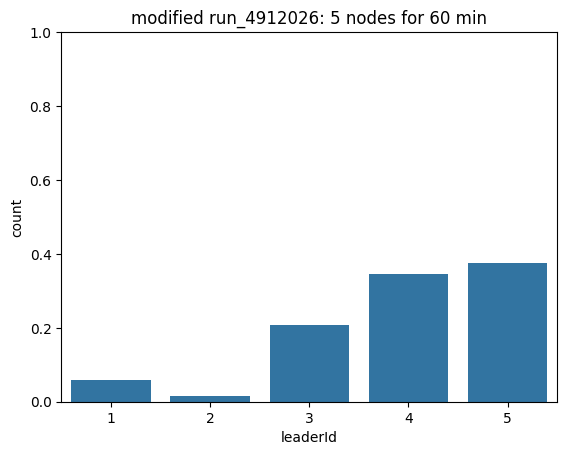

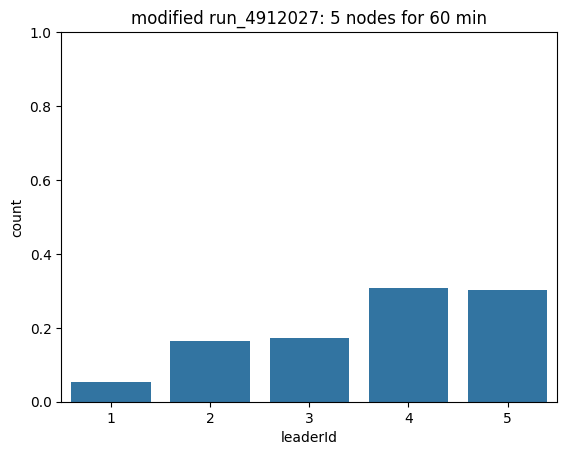

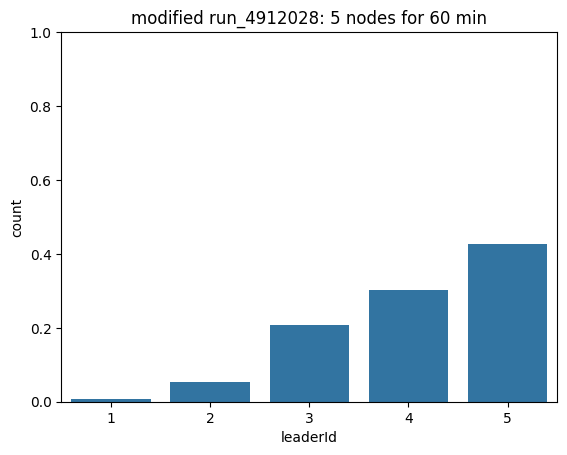

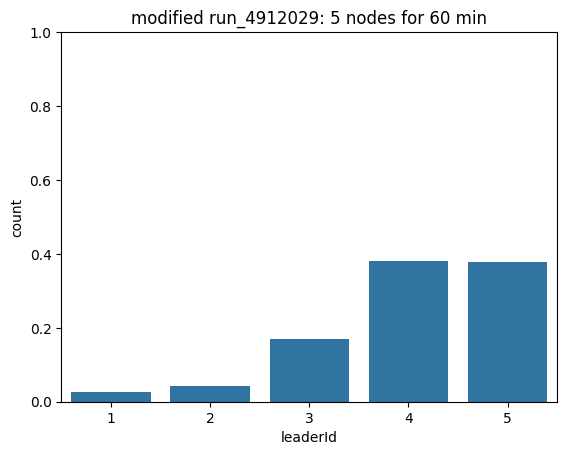

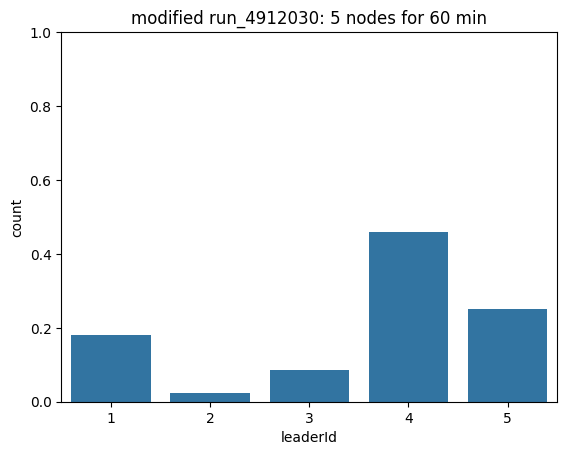

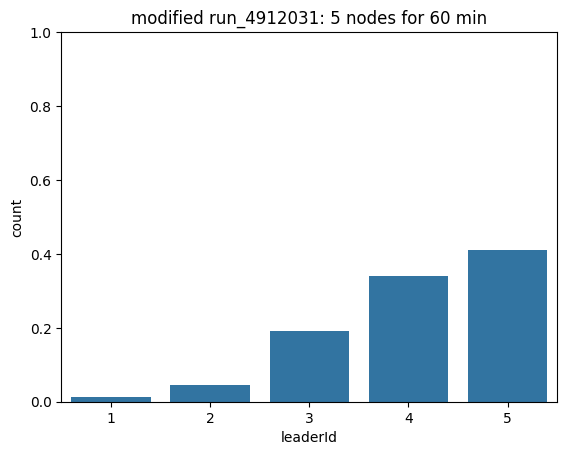

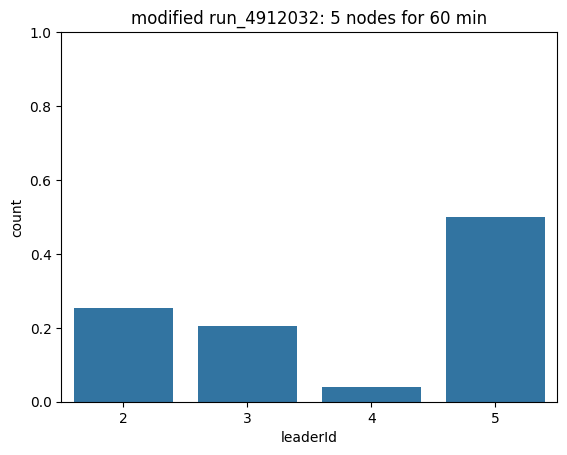

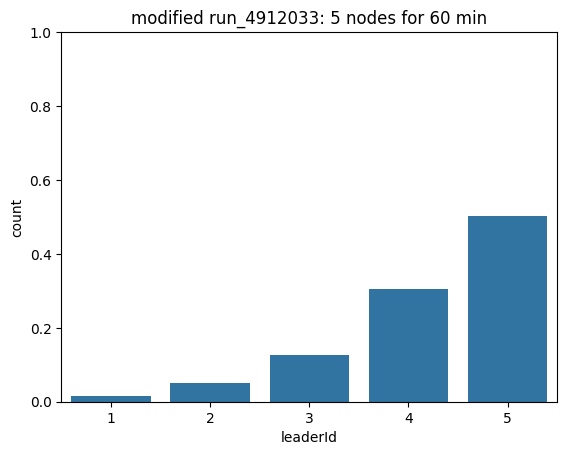

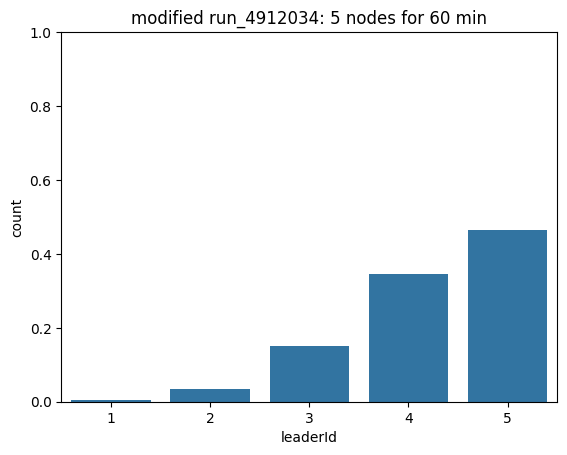

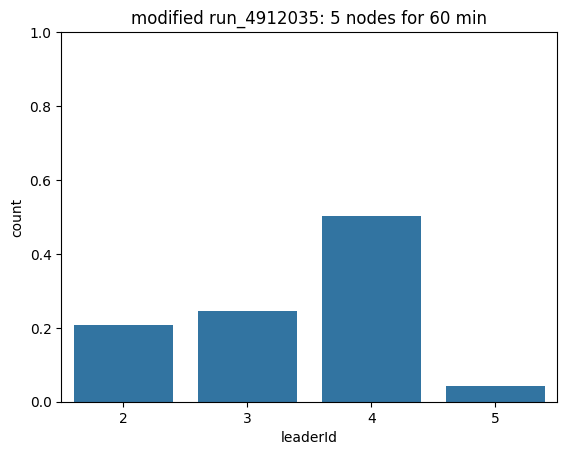

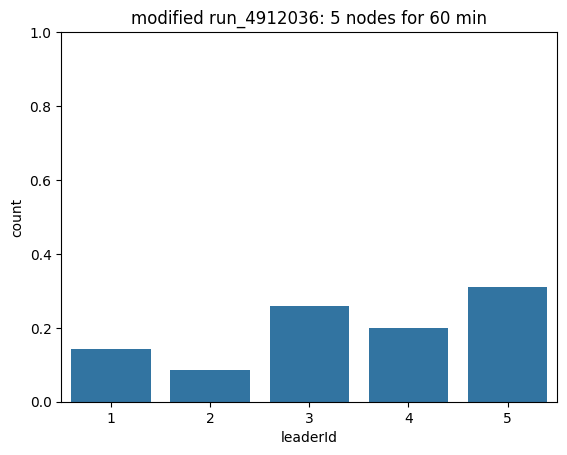

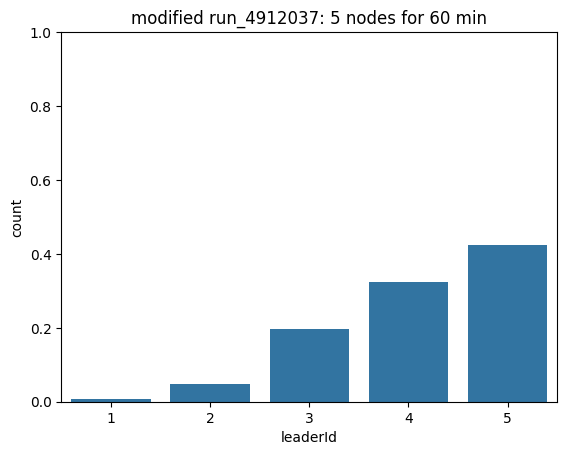

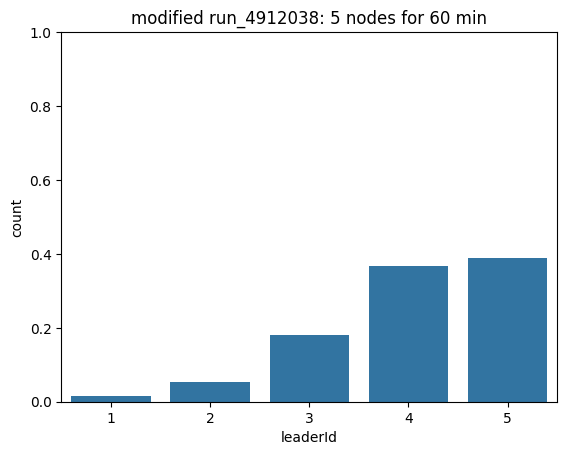

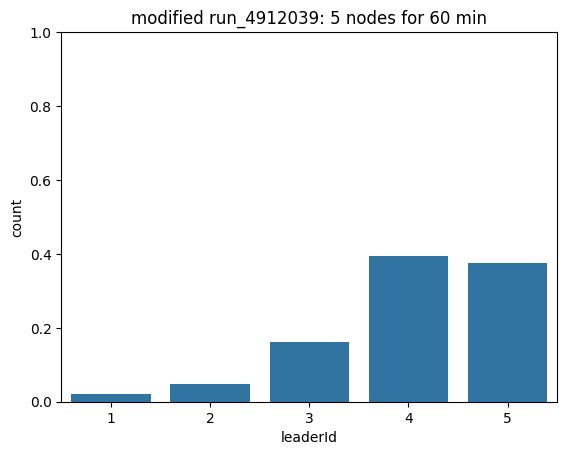

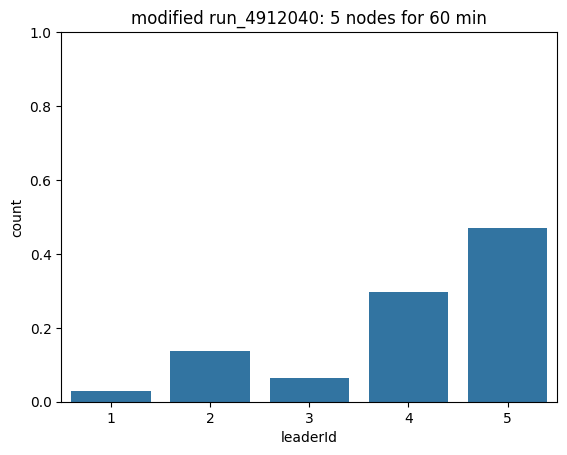

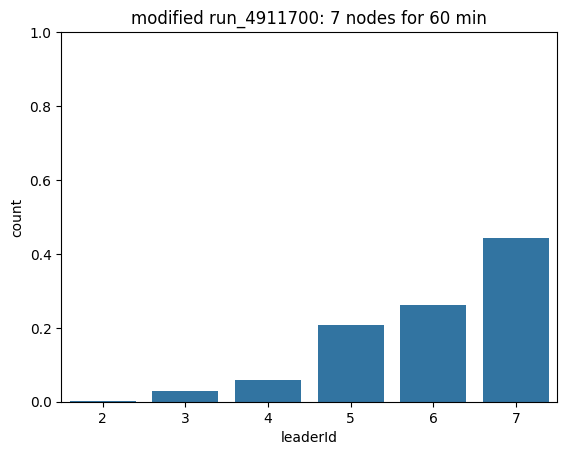

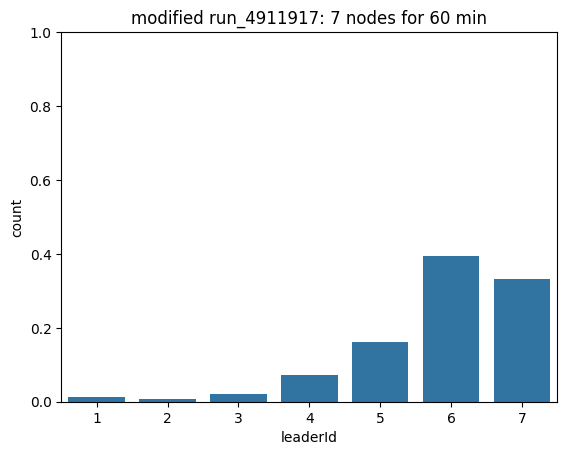

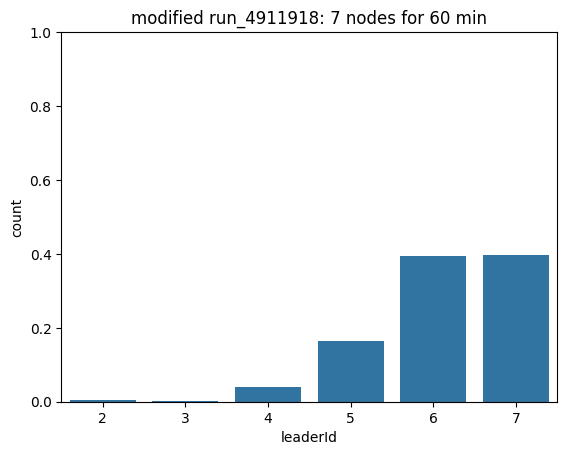

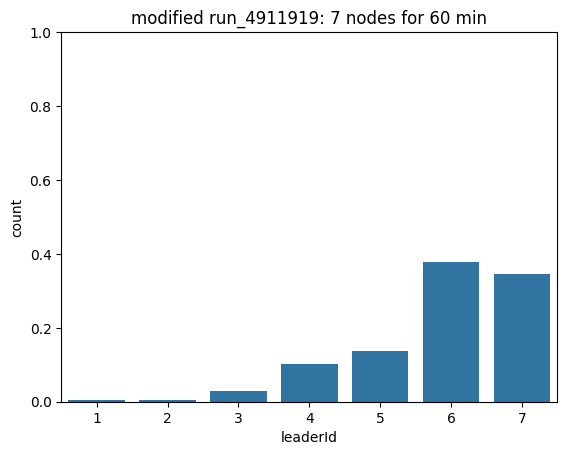

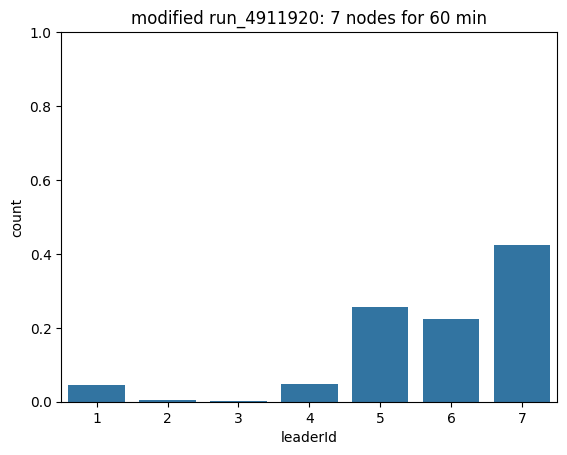

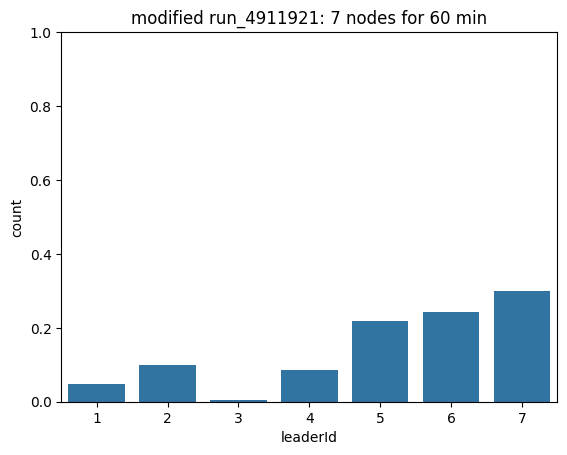

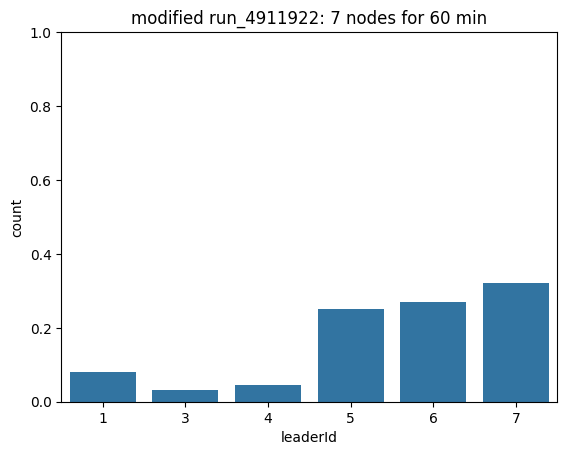

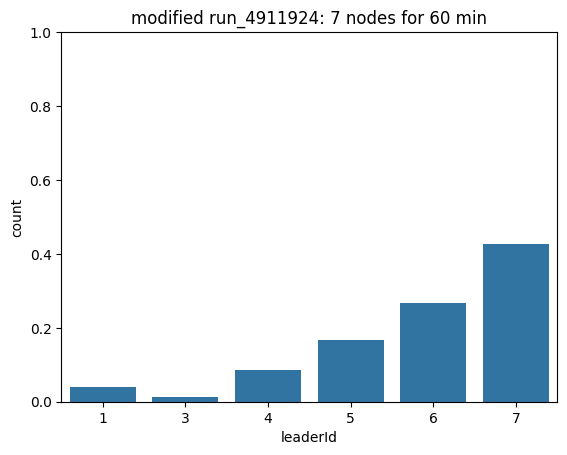

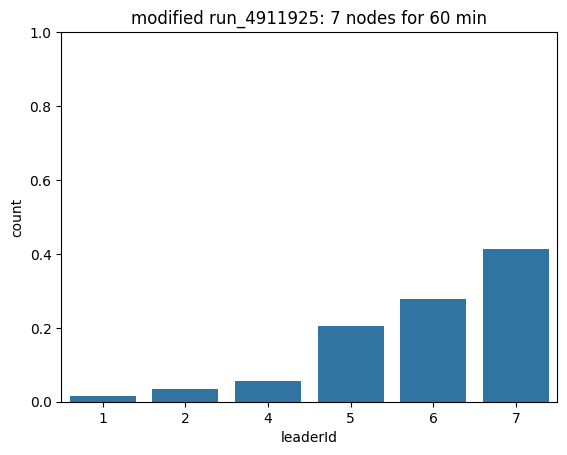

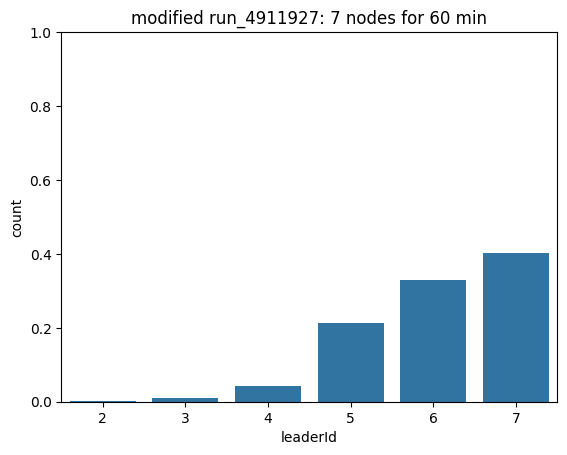

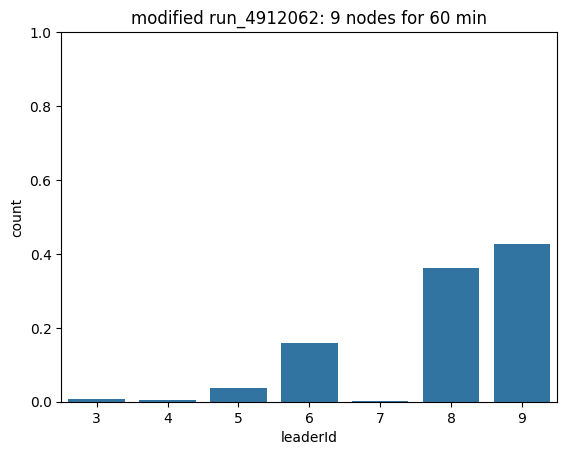

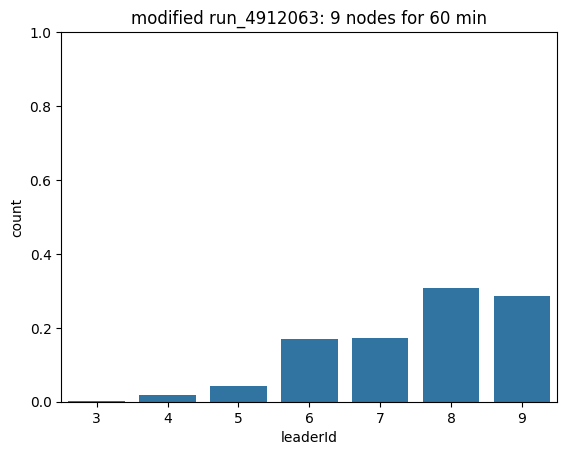

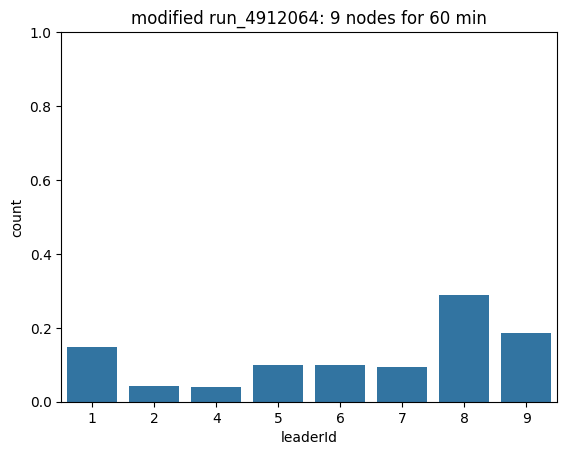

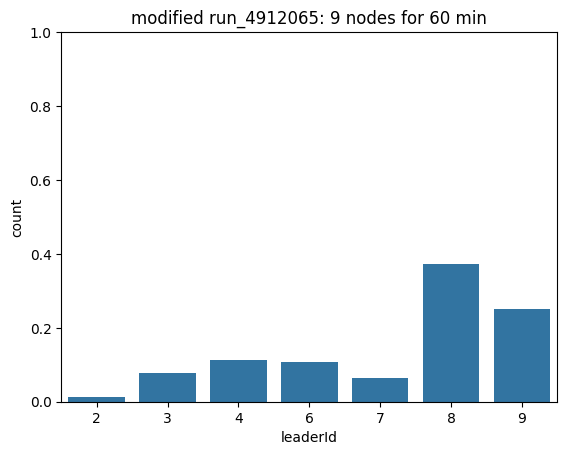

In [10]:
for file in FILES:
    algo = get_algorithm_type(file)
    nodes = get_node_count(file)
    minutes = get_duration_minutes(file)
    run = get_run_id(file)
    plot_leader_commit_counts(open_csv(file), f"{algo} {run}: {nodes} nodes for {minutes} min")

# Performance

## Entry Throughput

In [11]:
def find_replicated_count(df : pd.DataFrame, node_count : int) -> int:
    entry_counts = df.groupby('serverId').size()
    committed = []
    for count in entry_counts:
        replicated_count = sum(map(lambda x: x >= count, entry_counts))
        if replicated_count >= node_count:
            committed.append(count)
    return max(committed) if len(committed) > 0 else 0

def find_committed_count(df : pd.DataFrame) -> int:
    return find_replicated_count(df, find_quorum_size(df))

def find_fully_replicated_count(df : pd.DataFrame) -> int:
    return find_replicated_count(df, find_node_count(df))

In [12]:
def split_logs_by(df : pd.DataFrame, column : str) -> pd.DataFrame:
    logs : list[pd.DataFrame] = []
    for val in df[column].unique():
        logs.append(df[df[column] == val])
    return logs


In [13]:
def find_replication_delays(df : pd.DataFrame, num_nodes : int):
    logs = split_logs_by(df, "serverId")

    last_replicated = find_replicated_count(df, num_nodes)
    
    delays = []

    for i in range(last_replicated):
        creation_time = min([log.iloc[i]["creationTime"] for log in logs if len(log) > i])
        storage_times = [log.iloc[i]["storageTime"] for log in logs if len(log) > i]
        
        if len(storage_times) < num_nodes:
            delays.append(None)
            print(f"None at {i}. Need {num_nodes}, have {len(storage_times)}")
        else:
            storage_times.sort()
            delays.append(storage_times[num_nodes - 1] - creation_time)
    return delays
        

In [20]:
def process_data(paths : list[str], csv : str) -> pd.DataFrame:
    unprocessed_paths = []
    unprocessed_paths = paths
    existing_df = None

    algorithms = []
    node_counts = []
    durations_minutes = []
    run_ids = []
    dataframes = []
    full_replication_delays = []
    commit_delays = []
    committed_counts = []
    fully_replicated_counts = []
    committed_rates = []
    fully_replicated_rates = []
    longest_logs = []


    for file in tqdm(unprocessed_paths):
        df = open_csv(file)

        algorithms.append(get_algorithm_type(file))
        node_counts.append(get_node_count(file))
        durations_minutes.append(get_duration_minutes(file))
        run_ids.append(get_run_id(file))
        dataframes.append(df)
        full_replication_delays.append(find_replication_delays(df, find_node_count(df)))
        commit_delays.append(find_replication_delays(df, find_quorum_size(df)))
        committed_counts.append(find_committed_count(df))
        fully_replicated_counts.append(find_fully_replicated_count(df))
        longest_logs.append(find_replicated_count(df, 1))

    fully_replicated_rates = np.array(fully_replicated_counts) / RUNTIME_SECONDS
    committed_rates = np.array(committed_counts) / RUNTIME_SECONDS

    columns = {"path": paths, 
               "algorithm": algorithms, 
               "nodeCount": node_counts, 
               "duration": durations_minutes, 
               "runId": run_ids, 
               "fullReplicationDelays": full_replication_delays,
               "commitDelays": commit_delays,
               "fullReplicationCount": fully_replicated_counts, 
               "commitCount": committed_counts, 
               "fullReplicationRate": fully_replicated_rates,
               "commitRate": committed_rates,
               "longest_logs": longest_logs
               }
    new_entries = pd.DataFrame(columns)

    if existing_df is None:
       new_entries = new_entries.sort_values(by=["algorithm", "nodeCount", "runId"])
       new_entries.to_csv(csv)
       return new_entries
    else:
        result = pd.concat([existing_df, new_entries]).sort_values(by=["algorithm", "nodeCount", "runId"]).reindex()
        result.to_csv(csv)
        return result


paths = find_all_csvs("../bench_data/")
processed_path = "../bench_data/processed.csv"
DATA = process_data(paths, processed_path)
print(DATA.dtypes)
display(DATA)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [10:01<00:00,  6.02s/it]


path                      object
algorithm                 object
nodeCount                  int64
duration                   int64
runId                     object
fullReplicationDelays     object
commitDelays              object
fullReplicationCount       int64
commitCount                int64
fullReplicationRate      float64
commitRate               float64
longest_logs               int64
dtype: object


,path,algorithm,nodeCount,duration,runId,fullReplicationDelays,commitDelays,fullReplicationCount,commitCount,fullReplicationRate,commitRate,longest_logs
3,c:\Users\cursa\Documents\University\MSc CS\The...,classic,3,60,run_4911658,"[0.05020761489868164, 0.024514198303222656, 0....","[0.02578592300415039, 0.002036571502685547, 0....",32977,32977,9.160278,9.160278,32977
4,c:\Users\cursa\Documents\University\MSc CS\The...,classic,3,60,run_4911738,"[0.057538509368896484, 0.0276186466217041, 0.0...","[0.02727484703063965, 0.002354145050048828, 0....",31414,31426,8.726111,8.729444,31426
5,c:\Users\cursa\Documents\University\MSc CS\The...,classic,3,60,run_4911739,"[0.06940007209777832, 0.03997468948364258, 0.0...","[0.027065753936767578, 0.0026407241821289062, ...",32287,32318,8.968611,8.977222,32320
6,c:\Users\cursa\Documents\University\MSc CS\The...,classic,3,60,run_4911740,"[0.06718683242797852, 0.037453651428222656, 0....","[0.028225421905517578, 0.0029807090759277344, ...",32291,32297,8.969722,8.971389,32297
7,c:\Users\cursa\Documents\University\MSc CS\The...,classic,3,60,run_4911892,"[0.07047057151794434, 0.04250669479370117, 0.0...","[0.07047057151794434, 0.04250669479370117, 0.0...",30297,30297,8.415833,8.415833,30301
...,...,...,...,...,...,...,...,...,...,...,...,...
98,c:\Users\cursa\Documents\University\MSc CS\The...,modified,9,60,run_4912064,"[0.8625469207763672, 0.8351473808288574, 0.790...","[0.035680294036865234, 0.007039546966552734, 0...",4335,14673,1.204167,4.075833,16734
99,c:\Users\cursa\Documents\University\MSc CS\The...,modified,9,60,run_4912065,"[0.9018704891204834, 0.8721761703491211, 0.828...","[0.037531137466430664, 0.007585287094116211, 0...",3152,8889,0.875556,2.469167,10986
51,c:\Users\cursa\Documents\University\MSc CS\The...,modified,15,60,run_4912069,"[3.4873008728027344, 3.4486117362976074, 3.287...","[0.45661044120788574, 0.4209449291229248, 0.26...",86,1659,0.023889,0.460833,7650
52,c:\Users\cursa\Documents\University\MSc CS\The...,modified,15,60,run_4912070,"[3.5150861740112305, 3.476792097091675, 3.3160...","[0.04470658302307129, 0.008083820343017578, 0....",125,1051,0.034722,0.291944,10973


In [21]:
for file in FILES:
    df = open_csv(file)
    print(f"{file.split("bench_data", maxsplit=1)[1]}:\t committed {find_committed_count(df)}/{find_replicated_count(df, 1)},\t fully replicated {find_fully_replicated_count(df)}/{find_replicated_count(df, 1)}")

\classic\15_nodes\60_minutes\run_4912066\data_run_4912066.csv:	 committed 2544/8744,	 fully replicated 95/8744
\classic\15_nodes\60_minutes\run_4912067\data_run_4912067.csv:	 committed 4317/6042,	 fully replicated 172/6042
\classic\15_nodes\60_minutes\run_4912068\data_run_4912068.csv:	 committed 5370/6764,	 fully replicated 276/6764
\classic\3_nodes\60_minutes\run_4911658\data_run_4911658.csv:	 committed 32977/32977,	 fully replicated 32977/32977
\classic\3_nodes\60_minutes\run_4911738\data_run_4911738.csv:	 committed 31426/31426,	 fully replicated 31414/31426
\classic\3_nodes\60_minutes\run_4911739\data_run_4911739.csv:	 committed 32318/32320,	 fully replicated 32287/32320
\classic\3_nodes\60_minutes\run_4911740\data_run_4911740.csv:	 committed 32297/32297,	 fully replicated 32291/32297
\classic\3_nodes\60_minutes\run_4911892\data_run_4911892.csv:	 committed 30297/30301,	 fully replicated 30297/30301
\classic\3_nodes\60_minutes\run_4911893\data_run_4911893.csv:	 committed 32762/32762,